# Amazon Alexa Review
### Conduct Sentiment Analysis using Amazon Alexa Review Data - Supervised Machine Learning

In [1]:
from sklearn import metrics 
import numpy as np 
import pandas as pd 
import glob, os  
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

In [2]:
reviews = pd.read_csv('norm_amazon_alexa.csv')
reviews.shape

(3150, 7)

In [3]:
reviews.head(2)

,Unnamed: 0,rating,date,variation,verified_reviews,feedback,norm_review
0,0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,love echo
1,1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,love


In [4]:
reviews = reviews.dropna(subset = ['norm_review']).reset_index(drop=True)
reviews.shape

(3064, 7)

In [5]:
reviews.loc[:,['Unnamed: 0','norm_review','feedback']].feedback.map({1: 'positive', 0: 'negative'}).value_counts()

positive    2826
negative     238
Name: feedback, dtype: int64

In [6]:
reviews['polarity'] = reviews.feedback.map({1: 'positive', 0: 'negative'})

In [7]:
df_reviews = reviews.loc[:,['Unnamed: 0','norm_review','polarity']]\
                    .reset_index()\
                    .rename(columns={'index':'i','Unnamed: 0':'file_name','norm_review':'review_text'})
                    
df_reviews.head(2)

,i,file_name,review_text,polarity
0,0,0,love echo,positive
1,1,1,love,positive


In [8]:
import random
n = 3064
n_train = int(n*0.7)
n_test = n - n_train 

i_train = random.sample(range(n), n_train)
print('n_train:',n_train)
print('n_test:',n_test)

n_train: 2144
n_test: 920


In [9]:
def get_train_and_test(row):
    i = row['i']
    if i in i_train:
        return 'train'
    return 'test'

In [10]:
df_reviews['type'] = df_reviews.apply(get_train_and_test,axis=1)
df_reviews.head(2)

,i,file_name,review_text,polarity,type
0,0,0,love echo,positive,test
1,1,1,love,positive,train


In [11]:
doc_train = df_reviews.loc[df_reviews.type=='train',['file_name','review_text','polarity']]
doc_test  = df_reviews.loc[df_reviews.type=='test' ,['file_name','review_text','polarity']]

In [12]:
norm_reviews_train = doc_train['review_text']
norm_reviews_test  = doc_test['review_text']

### Tfidf:

In [13]:
vectorizer = TfidfVectorizer(ngram_range = (1,2)) 
feature_matrix_TRAIN = vectorizer.fit_transform(norm_reviews_train).astype(float)

# vectorizer_alt = TfidfVectorizer(ngram_range = (1,1)) 
# feature_matrix_TRAIN_alt = vectorizer_alt.fit_transform(norm_reviews_train).astype(float)

feature_matrix_TEST = vectorizer.transform(norm_reviews_test)
#feature_matrix_TEST_alt = vectorizer_alt.transform(norm_reviews_test)

### BOW: 

In [117]:
#from sklearn.feature_extraction.text import CountVectorizer

In [159]:
#bow_vectorizer = CountVectorizer(stop_words = 'english',ngram_range = (1,2)) 
#feature_matrix_TRAIN = bow_vectorizer.fit_transform(norm_reviews_train)

#feature_matrix_TEST = bow_vectorizer.transform(norm_reviews_test)

# Models

## 1. SVM:

Estimate the the classification model for sentiment analysis based on Support Vector Machines method and do prediction of sentiment polarity for the test data:

In [14]:
from sklearn import linear_model

sent_analysis_svm = linear_model.SGDClassifier(loss='hinge', random_state = 0) 
sent_analysis_svm.fit(feature_matrix_TRAIN, doc_train['polarity'])
predicted_svm = sent_analysis_svm.predict(feature_matrix_TEST) 

# sent_analysis_svm_alt = linear_model.SGDClassifier(loss='hinge',random_state = 0) 
# sent_analysis_svm_alt.fit(feature_matrix_TRAIN_alt, doc_train['polarity'])
# predicted_svm_alt = sent_analysis_svm_alt.predict(feature_matrix_TEST_alt)  

/Users/alicelyu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [15]:
from sklearn import metrics

true_labels = doc_test['polarity']
predicted_labels = predicted_svm
positive_class = 'positive'

print('SVM')

print('Accuracy:', np.round(metrics.accuracy_score(true_labels, 
                                                        predicted_labels), 3))

print('CONFUSION MATRIX:')
pd.crosstab(pd.Series(doc_test['polarity'].tolist()), 
            pd.Series(predicted_labels.tolist()), 
            rownames = ['True'], 
            colnames = ['Predicted'], 
            margins = True)

SVM
Accuracy: 0.95
CONFUSION MATRIX:


Predicted,negative,positive,All
True,,,
negative,21,38,59
positive,8,853,861
All,29,891,920


## 2. Logit:

In [16]:
sent_analysis_log = linear_model.SGDClassifier(loss='log', random_state = 0) 
sent_analysis_log.fit(feature_matrix_TRAIN, doc_train['polarity'])
predicted_log = sent_analysis_log.predict(feature_matrix_TEST) 

# sent_analysis_log_alt = linear_model.SGDClassifier(loss='log',random_state = 0) 
# sent_analysis_log_alt.fit(feature_matrix_TRAIN_alt, doc_train['polarity'])
# predicted_log_alt = sent_analysis_log_alt.predict(feature_matrix_TEST_alt)  

In [17]:
from sklearn import metrics

true_labels = doc_test['polarity']
predicted_labels = predicted_log
positive_class = 'positive'

print('Logit')

print('Accuracy:', np.round(metrics.accuracy_score(true_labels, 
                                                        predicted_labels), 3))

print('CONFUSION MATRIX:')
pd.crosstab(pd.Series(doc_test['polarity'].tolist()), 
            pd.Series(predicted_labels.tolist()), 
            rownames = ['True'], 
            colnames = ['Predicted'], 
            margins = True)

Logit
Accuracy: 0.946
CONFUSION MATRIX:


Predicted,negative,positive,All
True,,,
negative,11,48,59
positive,2,859,861
All,13,907,920


**BOOTSTRAPPING FOR MODEL COMPARISON:**

In [18]:
import numpy as np
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

Configure bootstrap: select number of iterations, sample size and generate observation ids:

In [19]:
n_iterations = 500
n_size = n_test
ids = range(n_size)

Display the accuracy for the original and the alternative models, as well as the difference in accuracy, delta:

In [20]:
svm_accuracy = np.round(metrics.accuracy_score(np.array(doc_test['polarity']), predicted_svm), 3)
log_accuracy = np.round(metrics.accuracy_score(np.array(doc_test['polarity']), predicted_log), 3)
delta_test = svm_accuracy - log_accuracy
print("Accuracy prediction, original: ", svm_accuracy)
print("Accuracy prediction, alternative: ", log_accuracy)
print("Difference in accuracy prediction: ", delta_test)

Accuracy prediction, original:  0.95
Accuracy prediction, alternative:  0.946
Difference in accuracy prediction:  0.0040000000000000036


Run the bootstrap:

In [21]:
svm_accuracy_boot = list()
svm_accuracy_boot_alt = list()


s = 0

for i in range(n_iterations):
    
    #prepare a pseudo test set
    test_ids = resample(ids, n_samples = n_size)
    actual_sentiments = np.array(doc_test['polarity'])[test_ids]
    
    #compute predictions on the pseudo sample
    svm_predicted     = sent_analysis_svm.predict(feature_matrix_TEST[test_ids])
    svm_predicted_alt = sent_analysis_log.predict(feature_matrix_TEST[test_ids])
    
    #compute accuracy for the pseudo sample
    svm_accuracy_boot_iter = metrics.accuracy_score(np.array(doc_test['polarity'])[test_ids], svm_predicted)
    svm_accuracy_boot_iter_alt = metrics.accuracy_score(np.array(doc_test['polarity'])[test_ids], svm_predicted_alt)

    delta = svm_accuracy_boot_iter - svm_accuracy_boot_iter_alt
    
    if delta > 1.5*delta_test:
        s = s+1
    
    pvalue = float(s)/n_iterations
    
    svm_accuracy_boot.append(svm_accuracy_boot_iter)
    svm_accuracy_boot_alt.append(svm_accuracy_boot_iter_alt)

p-value:  0.33
Mean accuracy for Original Model:  0.951
Mean accuracy for Alternative Model:  0.946


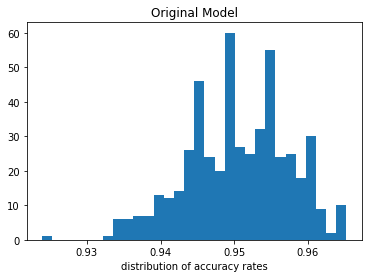

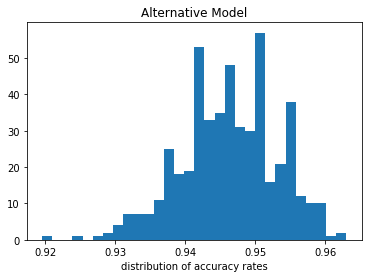

In [22]:
print('p-value: ', pvalue)
print('Mean accuracy for Original Model: ', np.round(np.mean(svm_accuracy_boot),3))
print('Mean accuracy for Alternative Model: ', np.round(np.mean(svm_accuracy_boot_alt),3))

import matplotlib.pyplot as plt

plt.hist(svm_accuracy_boot,bins = 30)
plt.xlabel("distribution of accuracy rates")
plt.title("Original Model")
plt.show()

plt.hist(svm_accuracy_boot_alt,bins = 30)
plt.xlabel("distribution of accuracy rates")
plt.title("Alternative Model")
plt.show()

Let's visualize the performance (accuracy) of the two models on the bostrapped test datasets by plotting the accuracy rates: 

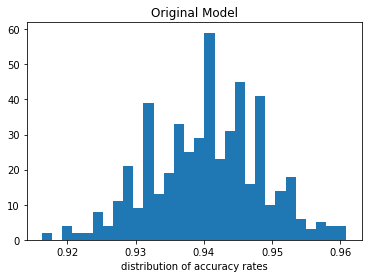

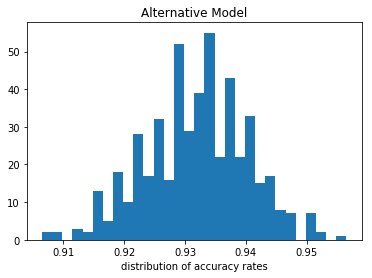

In [44]:
import matplotlib.pyplot as plt

plt.hist(svm_accuracy_boot,bins = 30)
plt.xlabel("distribution of accuracy rates")
plt.title("Original Model")
plt.show()

plt.hist(svm_accuracy_boot_alt,bins = 30)
plt.xlabel("distribution of accuracy rates")
plt.title("Alternative Model")
plt.show()

In [103]:
reviews.variation.value_counts()

Black  Dot                      494
Charcoal Fabric                 430
Configuration: Fire TV Stick    338
Black  Plus                     261
Black  Show                     258
Black                           257
Black  Spot                     235
White  Dot                      180
Heather Gray Fabric             151
White  Spot                     104
White                            88
Sandstone Fabric                 88
White  Show                      82
White  Plus                      75
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64

In [99]:
reviews.groupby(by=['variation']).mean()

,Unnamed: 0,rating,feedback
variation,,,
Black,520.988327,4.245136,0.867704
Black Dot,2791.726721,4.469636,0.931174
Black Plus,1917.674330,4.379310,0.896552
Black Show,1575.523256,4.492248,0.934109
Black Spot,1226.187234,4.336170,0.872340
Charcoal Fabric,529.634884,4.730233,0.972093
Configuration: Fire TV Stick,2275.931953,4.612426,0.926036
Heather Gray Fabric,529.165563,4.708609,0.986755
Oak Finish,461.785714,4.857143,1.000000
